In [36]:
#Text preprocessing
import nltk
from nltk.tokenize import word_tokenize #Tokenize words
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer #Creates one hot encoding of words
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#sklearn baseline models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression #model

#Deep learning modules
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D
import numpy as np
from keras.datasets import imdb
from keras.layers.normalization import BatchNormalization

#other
import os


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import data

### Fake news dataset

In [37]:
df_fake = pd.read_csv('data/Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [38]:
df_fake.text[1]

'House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Tr

### True News Dataset

In [39]:
df_true = pd.read_csv('data/True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [40]:
df_true.text[1]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition 

# Data Cleaning/Preprocessing

In [41]:
#################### 
# Add fake and true labels to each data frame
# Then combine data frame for further preprocessing 
####################

# Add columns for keepig track of labels
df_fake['label'] = int(1) #Add label 1 to fake news df
df_true['label'] = int(0) #Add label 0 to true news df

# Combine data frames
df = pd.concat([df_fake, df_true], axis = 0)

# Reset index
df = df.reset_index(drop = True)

#################### 
# Find cells that have no text in them using a lambda function
#Remove those cells with no text in them
####################

#Find cells with no text
df['no_text'] = df.apply(lambda x: x['text'] == ' ' or x['text'] == '  ' , axis = 1) 


#Remove those cells with no text
df = df[df['no_text'] == False]

# Reset index
df = df.reset_index(drop = True)

df.head()

,title,text,subject,date,label,no_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,False
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,False
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,False
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,False
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,False


# Create baseline model - Logistic Regression with Bag of Words

## For baseline model -  Create a 

In [42]:
####################
#Tokenize and clean sentences (Remove stopwords)
####################

#Calculate the number of rows
rows = df.shape[0]

#Initialize empty column
tokenized_sents = list()

# Loop through and tokenize words for each row
for current_row in range(0, rows):
    tokenizer = RegexpTokenizer(r"\w+")
    result = tokenizer.tokenize(df.text[current_row]) #Apple tokenizer
    result =  list(map(str.lower, result)) #Make every list element lowercase
    result = ' '.join(result)
    tokenized_sents.append(result)

In [43]:
####################
#Create document term matrix
####################

#Use count vectorizer
topn = 10000 #parameter for only top n most frequent words
countvec = CountVectorizer(max_features = topn) #Take top frequent words
countvec.fit(tokenized_sents) #Calculate the word frequency

#Get document term matrix
dtm = countvec.transform(tokenized_sents)

# Create pandas data frame from list of dictionaries  
word_freq_df = pd.DataFrame(dtm.toarray(), columns = countvec.get_feature_names())
word_freq_df.head()


,00,000,00pm,038,10,100,101,10th,11,110,...,zero,zika,zimbabwe,zimmerman,zinke,zone,zones,zor,zuckerberg,zuma
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create training and test sets

In [44]:
#################### 
# Create training and set (Does not factor in validation set)
# Perform stratified sampling
####################

# Assign predictors and dv to X and y
X = word_freq_df.to_numpy()
y  = df.label.tolist()

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                   random_state = 7,
                                                   stratify = y) 


# Run Logistic Regression

Logistic Accuracy = 0.9968375875310594


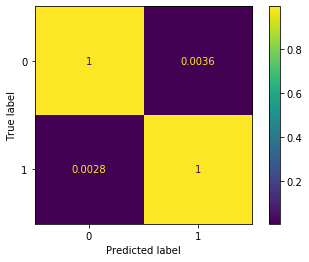

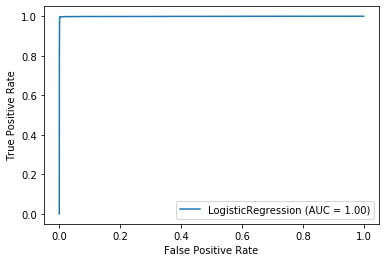

In [45]:
#Fit/train model
logisticRegr = LogisticRegression(max_iter = 500)
logisticRegr.fit(X_train, y_train)

#Test model
y_pred = logisticRegr.predict(X_test)
logisticRegr_accuracy = accuracy_score(y_test, y_pred)

#Evaluate model
print('Logistic Accuracy = {}'.format(logisticRegr_accuracy))
plot_confusion_matrix(logisticRegr, X_test, y_test, normalize='true')
plot_roc_curve(logisticRegr, X_test, y_test)

# Deep Feedforward neural network

In [46]:
#################### 
# Create train test set for feedforward eural network
####################

#Designate number of classes
num_classes = 2

#One hot encode trian and test dv
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

In [47]:
#################### 
# Create multilayer perceptron
####################

model = Sequential()
model.add(Dense(50, input_shape = (topn, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

In [48]:
batch_size = 32
epochs = 20

history = model.fit(X_train, 
                    y_train, 
                    batch_size = batch_size,
                    epochs = epochs, verbose = 1, 
                    validation_split=0.3)
score = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)

print("Test loss {}".format(score[0]))
print("Test accuracy {}".format(score[1]))


Epoch 1/20
678/678 [==============================] - 3s 5ms/step - loss: 0.1165 - accuracy: 0.9681 - val_loss: 0.0454 - val_accuracy: 0.9902
Epoch 2/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0296 - accuracy: 0.9929 - val_loss: 0.0366 - val_accuracy: 0.9931
Epoch 3/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0384 - val_accuracy: 0.9932
Epoch 4/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0466 - val_accuracy: 0.9914
Epoch 5/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0129 - accuracy: 0.9974 - val_loss: 0.0563 - val_accuracy: 0.9920
Epoch 6/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0469 - val_accuracy: 0.9930
Epoch 7/20
678/678 [==============================] - 3s 4ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.0621 - val_accuracy: 0.9911
Epoch 

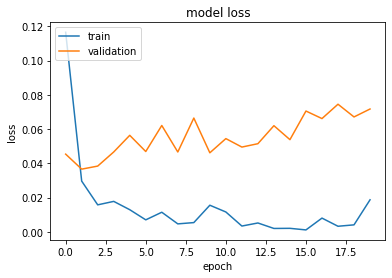

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Convolutional neural network

## Create training and test sets

In [50]:
#################### 
# Create training and set (Does not factor in validation set)
# Perform stratified sampling
####################

# Assign predictors and dv to X and y
X = df
y  = df.label.tolist()

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                   random_state = 7,
                                                   stratify = y) 

#################### 
# Create final training set and validation set
# Perform stratified sampling
####################
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                    test_size = 0.3,
                                                   random_state = 7,
                                                   stratify = y_train) 

## Convert pandas text column to list

In [51]:
#################### 
# Convert train, validation. and test text column to list
####################

#Convert training set to list
train_list = X_train.text.tolist()

#Convert test set to list
test_list = X_test.text.tolist()

#Convert validation set to list
validation_list = X_validation.text.tolist()

## Traing set calculations
1 = Fake News and 0 = True News

In [52]:
#################### 
# Calculate Percentage of fake and true news labels
####################

#Perecentage 
pecent_instances = df.label.value_counts()/(df.label.value_counts()[0] + df.label.value_counts()[1])

#Count
num_instances = df.label.value_counts()
print('Percentage of fake news instances = {}'.format(pecent_instances[1]))
print('Percentage of true news instances = {}'.format(pecent_instances[0]))

Percentage of fake news instances = 0.5162084622856755
Percentage of true news instances = 0.4837915377143244


## Make sure labels are in correct proportions

In [53]:
print("Percent of instances for stratifed sampling")
print(pecent_instances)
print("Percent of instances for stratifed sampling - training")
print(X_train.label.value_counts()/(X_train.label.value_counts()[0] + X_train.label.value_counts()[1]))
print("Percent of instances for stratifed sampling - test")
print(X_test.label.value_counts()/(X_test.label.value_counts()[0] + X_test.label.value_counts()[1]))
print("Percent of instances for stratifed sampling - validation")
print(X_validation.label.value_counts()/(X_validation.label.value_counts()[0] + X_validation.label.value_counts()[1]))

Percent of instances for stratifed sampling
1    0.516208
0    0.483792
Name: label, dtype: float64
Percent of instances for stratifed sampling - training
1    0.516183
0    0.483817
Name: label, dtype: float64
Percent of instances for stratifed sampling - test
1    0.516226
0    0.483774
Name: label, dtype: float64
Percent of instances for stratifed sampling - validation
1    0.516244
0    0.483756
Name: label, dtype: float64


In [54]:
#################### 
# Use Keras tokenizer function
####################

#Vocabular number
vocab = 1000

# Initialize and fit tokenizer (Converts text to lower case and finds unigrams)
t = Tokenizer(num_words = vocab)
t.fit_on_texts(train_list) 

#Create train, validation, and test sequences
train_sequences = t.texts_to_sequences(train_list)
validation_sequences = t.texts_to_sequences(validation_list)
test_sequences = t.texts_to_sequences(test_list)


#################### 
# convert sequences to be fed into neural network
####################
trainvaliddata = sequence.pad_sequences(train_sequences, maxlen = vocab, padding ='post')
validationdata = sequence.pad_sequences(validation_sequences, maxlen = vocab, padding = 'post')
testvaliddata = sequence.pad_sequences(test_sequences, maxlen = vocab, padding ='post')

#Designate number of classes
num_classes = 2

#One hot encode trian, validation, and test dv
y_train = to_categorical(np.array(X_train.label), num_classes = num_classes)
y_validation = to_categorical(np.array(X_validation.label), num_classes = num_classes)
y_test = to_categorical(np.array(X_test.label), num_classes = num_classes)

In [55]:
#################### 
# Create model and define parameters 
####################

# Parameters
vocab_size = 1000 #Remove less frequent words than top 999
maxlen = 1000
batch_size = 32
embedding_dims = 10
filters = 16
kernal_size = 3
hidden_dims = 250
epochs = 20


#Start model
model = Sequential()

#Add embedding layer
model.add(Embedding(input_dim = vocab_size,
                output_dim = embedding_dims,
                input_length = maxlen))

#Add dropout layer
model.add(Dropout(0.5))

#Add convolutional layer
model.add(Conv1D(filters = filters,
                kernel_size = kernal_size,
                padding = 'valid',
                activation = 'relu'))

#Add pooling layer
model.add(MaxPooling1D())

#Add convolutional layer
model.add(Conv1D(filters = filters,
                kernel_size = kernal_size,
                padding = 'valid',
                activation = 'relu'))

#Add pooling layer
model.add(MaxPooling1D())

#Flatten
model.add(Flatten())

#Add Dense layer
model.add(Dense(hidden_dims, activation = 'relu'))

#Add dropout layer
model.add(Dropout(0.5))

#Add Dense layer
model.add(Dense(2, activation = 'softmax'))


model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [56]:
history = model.fit(trainvaliddata, 
                    y_train, 
                    batch_size = batch_size,
                    epochs = epochs, verbose = 1, 
                    validation_data= (validationdata, y_validation),
                    )

Epoch 1/20
678/678 [==============================] - 5s 7ms/step - loss: 0.1435 - accuracy: 0.9283 - val_loss: 0.0167 - val_accuracy: 0.9953
Epoch 2/20
678/678 [==============================] - 4s 6ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.0092 - val_accuracy: 0.9980
Epoch 3/20
678/678 [==============================] - 4s 7ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0093 - val_accuracy: 0.9977
Epoch 4/20
678/678 [==============================] - 4s 6ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0051 - val_accuracy: 0.9985
Epoch 5/20
678/678 [==============================] - 4s 6ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 6/20
678/678 [==============================] - 4s 6ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 7/20
678/678 [==============================] - 4s 7ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0043 - val_accuracy: 0.9992
Epoch 

### Plot model loss and accuracy

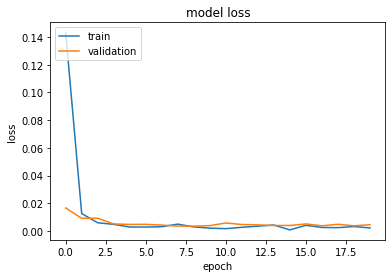

In [57]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

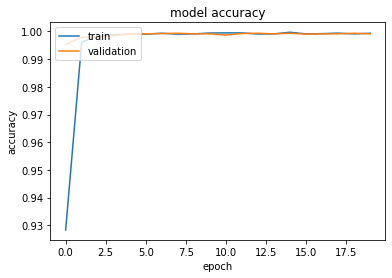

In [58]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Assess how well model performs on test set

In [59]:
#Predict test labels
y_pred = model.predict(np.array(testvaliddata))

#Plot confusion matrix
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


array([[6421,    4],
       [   5, 6851]], dtype=int64)

# Convolutional neural network (Using GloVe word embeddings)

## Download glove embeddings

In [60]:
#################### 
# Prepare embedding layer
####################

#Find directory of Glove embedding files
GLOVE_DIR = 'C:/Users/steve/OneDrive/SetonHall_Semesters/Fall 2020/Deep Learning/Final Project/glove.6B/'


embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Find embedding vector and match to corresponding corpus word

In [61]:
#################### 
# Compute embedding matrix
####################

#Get word index
word_index = t.word_index

#Asign value of embedding dimensions
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Create network

In [62]:
len(word_index)

101504

In [63]:
#################### 
# Create model and define parameters 
####################

# Parameters
vocab_size = 1000 #Remove less frequent words than top 999
maxlen = 1000
batch_size = 32
filters = 16
kernal_size = 3
hidden_dims = 250
epochs = 20


#Start model
model = Sequential()

#Add embedding layer
model.add(Embedding(input_dim = len(word_index) + 1,
                weights = [embedding_matrix],    
                output_dim = EMBEDDING_DIM,
                input_length = maxlen,
                trainable=False))

#Add dropout layer
model.add(Dropout(0.5))

#Add convolutional layer
model.add(Conv1D(filters = filters,
                kernel_size = kernal_size,
                padding = 'valid',
                activation = 'relu'))

#Add pooling layer
model.add(MaxPooling1D())

#Add convolutional layer
model.add(Conv1D(filters = filters,
                kernel_size = kernal_size,
                padding = 'valid',
                activation = 'relu'))

#Add pooling layer
model.add(MaxPooling1D())

#Flatten
model.add(Flatten())

#Add Dense layer
model.add(Dense(hidden_dims, activation = 'relu'))

#Add dropout layer
model.add(Dropout(0.5))

#Add Dense layer
model.add(Dense(2, activation = 'softmax'))


model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [64]:
history = model.fit(trainvaliddata, 
                    y_train, 
                    batch_size = batch_size,
                    epochs = epochs, verbose = 1, 
                    validation_data= (validationdata, y_validation),
                    )

Epoch 1/20
678/678 [==============================] - 5s 8ms/step - loss: 0.1974 - accuracy: 0.9127 - val_loss: 0.0126 - val_accuracy: 0.9977
Epoch 2/20
678/678 [==============================] - 5s 8ms/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.0103 - val_accuracy: 0.9981
Epoch 3/20
678/678 [==============================] - 5s 8ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0093 - val_accuracy: 0.9984
Epoch 4/20
678/678 [==============================] - 5s 7ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0128 - val_accuracy: 0.9983
Epoch 5/20
678/678 [==============================] - 5s 7ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0118 - val_accuracy: 0.9977
Epoch 6/20
678/678 [==============================] - 5s 7ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0113 - val_accuracy: 0.9981
Epoch 7/20
678/678 [==============================] - 5s 8ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0119 - val_accuracy: 0.9978
Epoch 

### Plot model loss and accuracy

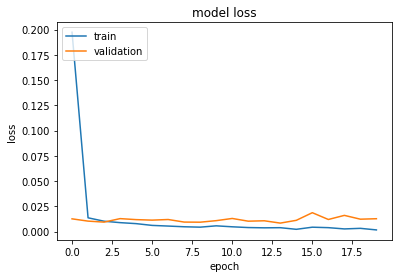

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

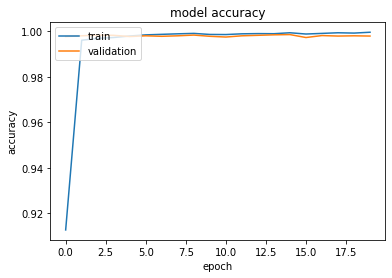

In [66]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Assess how well model performs on test set

In [67]:
#Predict test labels
y_pred = model.predict(np.array(testvaliddata))

#Plot confusion matrix
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


array([[6405,   20],
       [   3, 6853]], dtype=int64)